## Visualise Graphs for Joint Data

In [1]:
from interp.dataset import HDF5Dataset
from interp.dataset import nested_custom_collate
from torch.utils.data import DataLoader
import os

USE_SYNC = True

algorithms = ["bellman_ford", "bfs"]
if USE_SYNC:
    save_root = os.path.join("data", "_".join(algorithms) + "_sync")
else:
    save_root = os.path.join("data", "_".join(algorithms))

save_name = "interp_data_all"

# Load the saved datasets
train_dataset = HDF5Dataset(os.path.join(save_root, save_name + ".h5"), nested=True)
val_dataset = HDF5Dataset(os.path.join(save_root, save_name + "_eval.h5"), nested=True)

# Create DataLoaders
batch_size = 4
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    collate_fn=nested_custom_collate
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=nested_custom_collate
)

# Print some information about the datasets
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Check the first batch
sample_batch = next(iter(train_loader))
print("Sample batch keys:", sample_batch.keys())

for key in sample_batch.keys():
    algo_input = sample_batch[key]
    for field in algo_input.keys():
        print("algo", key, field, algo_input[field].shape)

Training dataset size: 3993
Validation dataset size: 999
Sample batch keys: dict_keys(['bellman_ford', 'bfs'])
algo bellman_ford batch torch.Size([39])
algo bellman_ford num_graphs torch.Size([])
algo bellman_ford num_nodes_per_graph torch.Size([4])
algo bellman_ford all_cumsum torch.Size([5])
algo bellman_ford edge_weights torch.Size([39, 39])
algo bellman_ford graph_adj torch.Size([39, 39])
algo bellman_ford gt_pi torch.Size([39])
algo bellman_ford hidden_states torch.Size([22, 128, 39])
algo bellman_ford timesteps_per_graph torch.Size([4])
algo bellman_ford all_cumsum_timesteps torch.Size([5])
algo bellman_ford start_node torch.Size([39])
algo bellman_ford upd_d torch.Size([22, 39])
algo bellman_ford upd_pi torch.Size([22, 39])
algo bfs batch torch.Size([39])
algo bfs num_graphs torch.Size([])
algo bfs num_nodes_per_graph torch.Size([4])
algo bfs all_cumsum torch.Size([5])
algo bfs edge_weights torch.Size([39, 39])
algo bfs graph_adj torch.Size([39, 39])
algo bfs gt_pi torch.Size([3

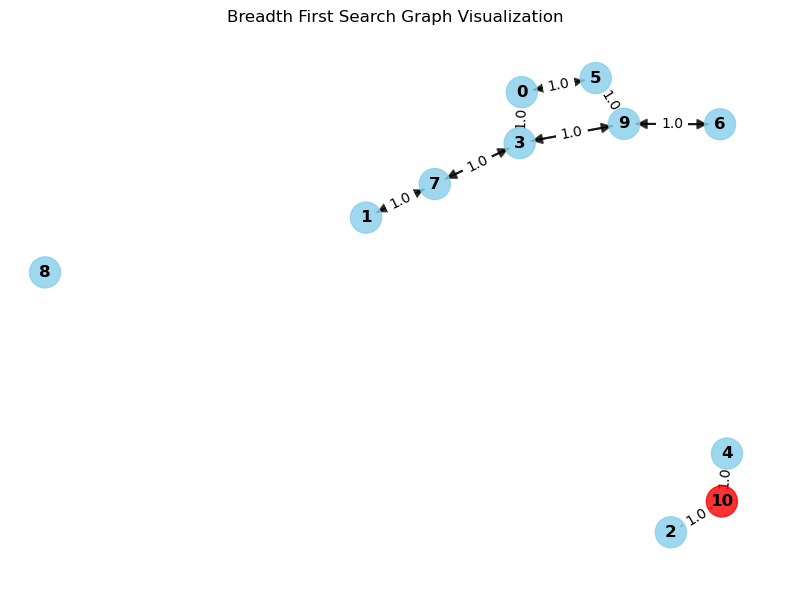

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1.]], dtype=torch.float64)
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        [ 0.,  1., 10.,  3., 10.,  5.,  6.,  7.,  8.,  9., 10.]],
       dtype=torch.float64)
tensor([[1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.],
        [0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1.]], dtype=torch.float64)


In [6]:
from interp.visualisation import visualize_graph
import matplotlib.pyplot as plt
import random

random_idx = random.randint(0, len(train_dataset)-1)
datapoint = train_dataset[random_idx]
# Example usage
fig, ax = visualize_graph(datapoint['bfs'], title="Breadth First Search Graph Visualization")
plt.show()
print(datapoint['bfs']['upd_d'])
print(datapoint['bfs']['upd_pi'])
print(datapoint['bfs']['edge_weights'])

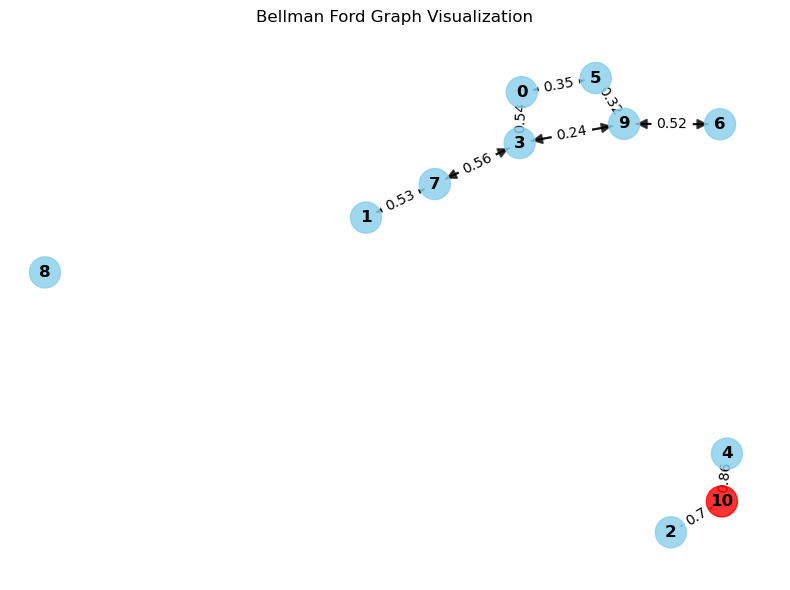

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.0000, 0.6978, 0.0000, 0.8616, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000]], dtype=torch.float64)
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        [ 0.,  1., 10.,  3., 10.,  5.,  6.,  7.,  8.,  9., 10.]],
       dtype=torch.float64)
tensor([[0.3406, 0.0000, 0.0000, 0.5404, 0.0000, 0.3452, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.0978, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5256, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.0000, 0.3351, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.6978],
        [0.5404, 0.0000, 0.0000, 0.4348, 0.0000, 0.0000, 0.0000, 0.5554, 0.0000,
         0.2373, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.3482, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.8616],
        [0.3452, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.000

In [7]:
fig, ax = visualize_graph(datapoint['bellman_ford'], title="Bellman Ford Graph Visualization")
plt.show()
print(datapoint['bellman_ford']['upd_d'])
print(datapoint['bellman_ford']['upd_pi'])
print(datapoint['bellman_ford']['edge_weights'])

In [32]:
# Testing if samples are synchronous
# i.e. same graph structure per instance
(sample_batch['bellman_ford']['graph_adj'] == sample_batch['bfs']['graph_adj']).all()

tensor(False)

# Visualise single algorithm Data

In [6]:
# Load the saved dataset and check shapes after collation
import os
from interp.dataset import custom_collate
from torch.utils.data import DataLoader
from interp.dataset import HDF5Dataset

alg = "bellman_ford"
save_root = os.path.join("data", alg)
save_name = "interp_data_all"

# Load the saved datasets
train_dataset = HDF5Dataset(os.path.join(save_root, save_name + ".h5"))
val_dataset = HDF5Dataset(os.path.join(save_root, save_name + "_eval.h5"))

# Create dataloaders with the custom_collate function
batch_size = 4  # Small batch size for demonstration
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)

# Get a sample batch from the dataloader
sample_batch = next(iter(train_dataloader))

# Print the shapes of each entry in the batch
print("Sample batch shapes after collation:")
for key, value in sample_batch.items():
    if hasattr(value, 'shape'):
        print(f"{key}: {value.shape}")
    elif isinstance(value, list):
        print(f"{key}: list of length {len(value)}")
    else:
        print(f"{key}: {type(value)}")

# Close the HDF5 files when done
train_dataset.close()
val_dataset.close()


Sample batch shapes after collation:
batch: torch.Size([29])
num_graphs: torch.Size([])
num_nodes_per_graph: torch.Size([4])
all_cumsum: torch.Size([5])
edge_weights: torch.Size([29, 29])
graph_adj: torch.Size([29, 29])
gt_pi: torch.Size([29])
hidden_states: torch.Size([12, 128, 29])
timesteps_per_graph: torch.Size([4])
all_cumsum_timesteps: torch.Size([5])
start_node: torch.Size([29])
upd_d: torch.Size([12, 29])
upd_pi: torch.Size([12, 29])


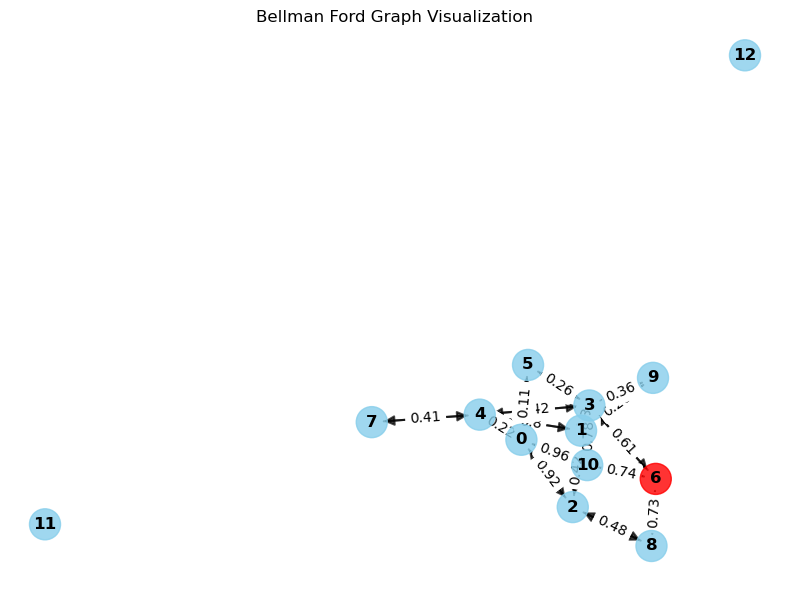

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.6116, 0.0000, 0.0000, 0.0000, 0.0000, 0.7342,
         0.0000, 0.7356, 0.0000, 0.0000],
        [1.6982, 0.9151, 1.2132, 0.0000, 1.0331, 0.8750, 0.0000, 0.0000, 0.0000,
         0.9674, 0.0000, 0.0000, 0.0000],
        [0.9860, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.4385, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000]], dtype=torch.float64)
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.],
        [ 0.,  1.,  2.,  6.,  4.,  5.,  6.,  7.,  6.,  9.,  6., 11., 12.],
        [10.,  3.,  8.,  3.,  3.,  3.,  6.,  7.,  8.,  3., 10., 11., 12.],
        [ 5.,  1.,  2.,  3.,  4.,  5.,  6.,  4.,  8.,  9., 10., 11., 12.]],
       dtype=torch.float64)


In [7]:
from interp.visualisation import visualize_graph
import matplotlib.pyplot as plt
import random

random_idx = random.randint(0, len(train_dataset)-1)
datapoint = train_dataset[random_idx]
# Example usage
fig, ax = visualize_graph(datapoint, title="Bellman Ford Graph Visualization")
plt.show()
print(datapoint['upd_d'])
print(datapoint['upd_pi'])